In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm.notebook import tqdm 
import datetime
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, Normalizer, StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits, load_iris

from numpy.linalg import norm
import pickle

## Personal Imports
from my_model_e2 import FFNetwork
from db_creator import Dataset

## DETAILS
# Here we will plot our bound and the actual generalization error.
# FIX m and w, for non over parameterized setting.
# 
# SUMMARY-
# For OUR BOUND-
#   There are 3 selections- z', ith_point, random_string
#   I am doing this randomly for say t times, and then taking the mean of Lipschitz
#    constant for every epoch. And then max over all epochs to get LP and SM const.
#
# For Our bound- 
#   We need to calculate lipschitz and smoothness constant.
#     - I am using the local smoothness constant
#     - can use global i.e. need to calculate max(K_t, (f(w) - f(w'))/delta_t ) # DO IT LATER
#   We need to perform this multiple times, as we will get different ith point each time.
#    and then take the max(should be mean as expectation over r) of the lipschitz constant
#    across all experiments and (across all epochs)?, for the given K and L we will use
#    our bound to get the result. i.e we will keep changing m in our formulae and plot the
#    values we get,
#   We can do it just 50-60 times as we don't need delta_t, or loss_diff of two models.
#   IMP we shold use same order across all experiments with just ith point getting changed?
# For generalization error-
#   We calculate it using models validation loss - models train loss, we do this for every
#    step. ALso for every experiment (i.e. t times) we will do this and take the mean 
#    (or else how to plot exact as its R(S,A,r) - Re(S,A,r)) and we will get list of the 
#    generalization error as m increases.
#  
# Others-
#   Wriuting code such that we can make 2 sets

In [2]:
use_db = 'iris'
result_root_dir='results/t1/'
result_path='try_'
book_keep_freq = 10
g_times = 10
g_weight = 20
g_epochs = 1
alpha_0= 0.1
exp_times_limit = 1000
training_step_limit = 1000000




op_features = 5
if use_db == 'page-blocks':
    X_train, Y_train, X_val, Y_val = Dataset().get_page_blocks('datasets/page-blocks.data')
    # input_features = 10
    op_features = 5
elif use_db == 'iris':
    X_train, Y_train, X_val, Y_val = Dataset().get_iris()
    # input_features = 4
    op_features = 3

def get_replaced_index_same_order(X_train):
    
    ## Forcing this function to be random ##
    # seed_num = datetime.datetime.now().microsecond
    # np.random.seed(seed_num)
    #######################################
    
    replaced_index = 0
    index = np.arange(X_train.shape[0])
    zd_index = np.random.choice(index)
    # print('index pf point to pick out:', zd_index)
    S1_ind = [i for i in index if i != zd_index]
    # print('S1_ind:',S1_ind)
    S2_ind = S1_ind
    ith_point = np.random.choice(index[:-1])
    # print('ith_point:', ith_point)
    S2_ind[ith_point] = zd_index
    # print('S2_ind:',S2_ind)
    return S1_ind, S2_ind, ith_point

def get_replaced_index(X_train):
    
    ## Forcing this function to be random ##
    seed_num = datetime.datetime.now().microsecond
    np.random.seed(seed_num)
    #######################################
    
    replaced_index = 0
    index = np.arange(X_train.shape[0])
    np.random.shuffle(index)

    S_ind = index[:-1]
    S_d_ind = np.append(index[:-2], index[-1:])
    ind_temp = np.arange(len(S_ind))
    np.random.shuffle(ind_temp)
    for i,l in enumerate(ind_temp):
        if l == len(S_ind)-1:
            replaced_index = i
            # print('replaced index :', replaced_index)
            break

    S_ind = S_ind[ind_temp]
    S_d_ind = S_d_ind[ind_temp]
    # print('S index :', S_ind)
    # print('S\' index:', S_d_ind)
    return S_ind, S_d_ind, replaced_index

X,Y train (100, 4) (100,)
X,Y val (50, 4) (50,)


In [3]:
# model_test = FFNetwork(num_hidden=20, input_features=4, op_features=op_features, 
#                           random_initialization=False, lr_decay=True)
# model_test.fit_b(
#         X=X_train, Y=Y_train, epochs=5, eta=0.01, batch_size=1,
#         X_val=X_val, Y_val=Y_val, training_step_limit=training_step_limit,
#         book_keep_grads=True, book_keep_hessian=True, 
#         book_keep_weights=True, book_keep_gen_err=True)

In [4]:
# model_test.get_accuracy(X_val,Y_val)

In [5]:
def exp_once(X, Y, X_val, Y_val,weights, epochs=1, lr_rate = 1):
    
    '''
    args: X,Y,X_val, Y_val, epochs - standard inputs as the name suggest
    About: This function performs 1 experiment, It selects 1 random ith point
    creates set S1 and S2 and train models on these, we save the weights of 
    these models and calculate the norm of difference of weights (at every epoch) and append it to a file.
    
    About randomness
    Both the models use random initialization and for random_initialization = Flase, they set seed(0)
    during object creation so since both the models are called with random_initialization = False they
    both get initialized with the same weight values
    '''
    
    book_keep_grads=True
    book_keep_hessian=True
    book_keep_gen_err=True
    book_keep_weights = True
    use_model2 = False
    
    order_of_permute = []
    # To fix order of permute of both the models
    for epoch in range(epochs):
        order_of_permute.append(np.arange(X.shape[0]))
    
    # S1_ind, S2_ind, ith_pos = get_replaced_index(X)
    S1_ind, S2_ind, ith_pos = get_replaced_index_same_order(X)
    input_features = X.shape[1]
    print('ith position  :', ith_pos)
    # print('Input_features:',input_features)
    
    model1 = FFNetwork(num_hidden=weights, input_features=input_features, op_features=op_features, 
                          random_initialization=False, lr_decay=True)
    model1.fit_b(
            X=X[S1_ind], Y=Y[S1_ind], epochs=epochs, eta=lr_rate, batch_size=1,
            X_val=X_val, Y_val=Y_val, training_step_limit=training_step_limit,
            order_of_permute=order_of_permute,book_keep_freq = book_keep_freq,
            book_keep_grads=book_keep_grads, book_keep_hessian=book_keep_hessian, 
            book_keep_weights=book_keep_weights, book_keep_gen_err=book_keep_gen_err)
    
    if use_model2:
        model2 = FFNetwork(num_hidden=weights, input_features=input_features, op_features=op_features, 
                              random_initialization=False, lr_decay=True)
        model2.fit_b(
                X=X[S2_ind], Y=Y[S2_ind], epochs=epochs, eta=lr_rate, batch_size=1,
                X_val=X_val, Y_val=Y_val, training_step_limit=training_step_limit,
                order_of_permute=order_of_permute,book_keep_freq = book_keep_freq,
                book_keep_grads=book_keep_grads, book_keep_hessian=book_keep_hessian, 
                book_keep_weights=book_keep_weights, book_keep_gen_err=book_keep_gen_err)
    
    gen_err1 = model1.generalization_err
    weight1 = model1.w
    # l1 = np.array(model1.loss_list)
    # lp1 = np.array(model1.point_loss_list)
    grads1 = model1.grads_norm
    hess_norm1 = model1.hess_norms
    
    if use_model2:
        gen_err2 = model2.generalization_err
        weight2 = model2.w
        # l2 = np.array(model2.loss_list)
        # lp2 = np.array(model2.point_loss_list)
        grads2 = model2.grads_norm
        hess_norm2 = model2.hess_norms
    else:
        gen_err2 = []
        weight2 = []
        l2 = []
        lp2 = []
        grads2 = []
        hess_norm2 = []
    
    return np.array(gen_err1), np.array(gen_err2), np.array(weight1), np.array(weight2), grads1, grads2, hess_norm1, hess_norm2

def exp2_multiple_run(X, Y, X_val, Y_val, weights, times, lr_rate, root_dir='', path=None, epochs = 1, clear_files = True):
    delta_t_list = []
    gen_err_list = []
    loss_diff_list = []
    point_loss_diff_list = []
    grad_norm_list = []
    hess_norm_list = []
    gen_err_list = []
    if path is not None:
        grad_file_path = root_dir+'grad_'+path
        hess_file_path = root_dir+'hess_'+path
        gen_file_path  = root_dir+'gen_'+path
    if clear_files and path is not None:
        with open(grad_file_path, 'w+') as f:
            f.write('')
        with open(hess_file_path, 'w+') as f:
            f.write('')
        with open(gen_file_path, 'w+') as f:
            f.write('')
    
    for t in range(min(times, exp_times_limit)):
        gen_err1, gen_err2, w1, w2, grads1, grads2, hess_norm1, hess_norm2 = exp_once(X,Y, X_val, Y_val,weights, epochs, lr_rate= lr_rate)
        
        grad_norm_list.append(grads1)
        hess_norm_list.append(hess_norm1)
        gen_err_list.append(gen_err1)
        
        if path is not None:
            with open(grad_file_path,'a+') as f:
                f.write(' '.join([str(grad) for grad in grads1]) + '\n')
            with open(hess_file_path,'a+') as f:
                f.write(' '.join([str(grad) for grad in hess_norm1]) + '\n')
            with open(gen_file_path,'a+') as f:
                f.write(' '.join([str(grad) for grad in gen_err1]) + '\n')
        
    return grad_norm_list, hess_norm_list, gen_err_list

In [30]:
grad_list, hess_list, gen_err_list = exp2_multiple_run(X_train, Y_train, X_val=X_val, Y_val=Y_val, weights=g_weight, times=g_times, lr_rate=alpha_0, root_dir=result_root_dir, path=result_path, epochs=g_epochs)

ith position  : 3
ith position  : 51
ith position  : 55
ith position  : 23
ith position  : 38
ith position  : 55
ith position  : 94
ith position  : 6
ith position  : 72
ith position  : 57


In [6]:
def get_lp_sm(grad_list, hess_list):
    mean_grads_per_update = np.mean(np.array(grad_list), axis=0)
    lp_const = np.max(mean_grads_per_update)
    
    mean_hess_per_update = np.mean(np.array(hess_list), axis=0)
    sm_const = np.max(mean_hess_per_update)
    return lp_const, sm_const

def our_bound_computatio(K_g, L_g, m, t, alpha_0, way='normal'):
    beta = 1
    alpha_lg = alpha_0*L_g
    print('alpha_0 L_g (<=0.5?):',alpha_lg)
    if way == 'normal':
        F = np.power(t/m, 2*alpha_lg)
        F = F*np.power(2, t/m)
        # print('F', F)
        beta = (1+alpha_lg)*np.power(K_g,2)/L_g
        beta = beta* F/(np.power(m, 1-2*alpha_lg))
    est_gen_err = beta + 2*beta*np.sqrt(m)
    return est_gen_err

In [7]:
K_g, L_g = get_lp_sm(grad_list, hess_list)
print('Lipschitz constant:', K_g)
print('Smoothness constant:', L_g)

NameError: name 'grad_list' is not defined

In [9]:
### Saving exp details
details={}
details['Times'] = g_times
details['Dataset'] = use_db
details['book_keep_freq'] = book_keep_freq
details['Weights'] = g_weight
details['Epochs'] = g_epochs
details['alpha_0'] = alpha_0
details['Lipschitz constant'] = K_g
details['Smoothness constant'] = L_g

# with open(result_root_dir+'details_'+result_path+'.txt', 'w+') as f:
#     for key, val in details.items():
#         content = key + ' : '+str(val) + '\n'
#         f.write(content)

NameError: name 'K_g' is not defined

In [10]:
m = np.arange(1,X_train.shape[0])
t = m
val = our_bound_computatio(K_g=K_g, L_g=L_g, m=m, t=t, alpha_0=alpha_0)

NameError: name 'K_g' is not defined

In [8]:
def plot_bound_gen_err(bound, gen_error, path=None, ylimits = None):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_yscale('log')
    if ylimits is not None:
        ax.set_ylim(ylimits[0],ylimits[1])
    ax.grid()
    ax.plot(bound, label= 'our_bound')
    ax.plot(np.abs(np.mean(gen_error, axis=0)), label='gen_err')
    ax.set_xlabel('Number of Updates')
    ax.set_ylabel('Generalization errors')
    ax.legend()
    if path is not None:
        plt.savefig(path)

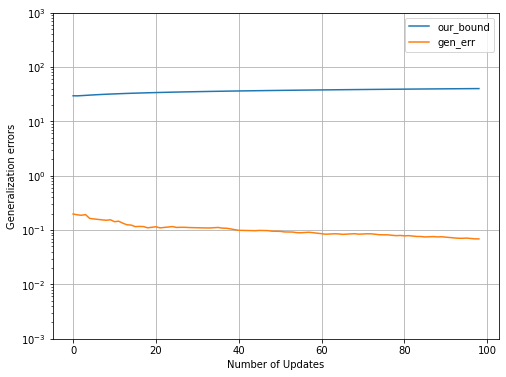

In [26]:
plot_bound_gen_err(val, gen_err_list)

In [9]:
def get_exp_details(root_dir, path):
    result_details={}
    details_path = root_dir+ 'details_'+ path + '.txt'
    with open(details_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        key, val = line[:-1].split(':')
        key, val = key.strip(' '), val.strip(' ')
        if key not in ['Times', 'Weights', 'Epochs', 'Dataset', 'book_keep_freq']:
            val = float(val)
        if key in ['Times', 'Weights', 'Epochs', 'book_keep_freq']:
            val = int(val)
        result_details[key] = val
    return result_details
def get_exp_results(root_dir, path, result_details):
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        grad_list.append([float(l) for l in line[:-1].split(' ')])
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        hess_list.append([float(l) for l in line[:-1].split(' ')])
        
    with open(gen_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        gen_err_list.append([float(l) for l in line[:-1].split(' ')])
    
    K_g = result_details['Lipschitz constant']
    L_g = result_details['Smoothness constant']
    alpha_0 = result_details['alpha_0']
    book_keep_freq = result_details['book_keep_freq']
    m = book_keep_freq*np.arange(1,len(gen_err_list[0]))
    t = m
    bound = our_bound_computatio(K_g=K_g, L_g=L_g, m=m, t=t, alpha_0=alpha_0)
    
    return grad_list, hess_list, gen_err_list, bound

In [10]:
result_details = get_exp_details('results/t4/', 'try2_mnist')
result_details

{'Times': 1,
 'Dataset': 'mnist',
 'book_keep_freq': 100,
 'Weights': 10,
 'Epochs': 1,
 'alpha_0': 0.03,
 'Lipschitz constant': 0.9540034852038188,
 'Smoothness constant': 14.134640963421894}

In [12]:
def get_our_bound1(K_g, L_g, m, t, alpha_0, way='normal'):
    beta = 1
    F = 1
    alpha_lg = alpha_0*L_g
    print('alpha_0 L_g (<=0.5?):',alpha_lg)
    if way == 'normal':
        F = np.power(t/m, 2*alpha_lg)
        F = F*np.power(2, t/m)
        # print('F', F)
    beta = (1+alpha_lg)*np.power(K_g,2)/L_g
    beta = beta* F/(np.power(m, 1-2*alpha_lg))
    est_gen_err = beta + 2*beta*np.sqrt(m)
    return est_gen_err

# m = np.arange(1,50000)
# t = m
# plt.plot(get_our_bound1(2.7, 0.2, m, t, 0.01, 'single_epoch'))
# plt.yscale('log')
# plt.ylim(0.001, 10)

In [13]:
grad_list, hess_list, gen_err_list, our_bound = get_exp_results('results/t4/', 'try2_mnist', result_details=result_details)

alpha_0 L_g (<=0.5?): 0.42403922890265683


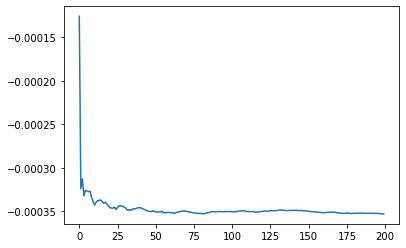

In [20]:
plt.plot(gen_err_list[0])

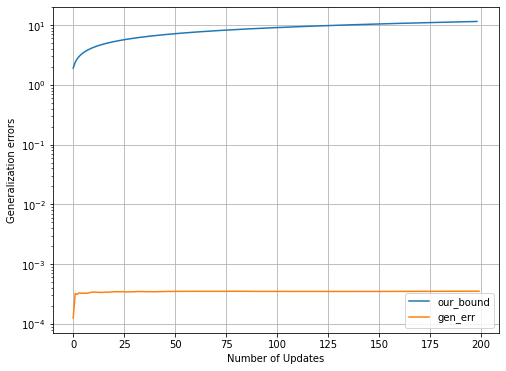

In [15]:
# plot_bound_gen_err(our_bound, gen_err_list, path='results/t3/plot_try1.png')
plot_bound_gen_err(our_bound, gen_err_list, path=None, ylimits = None)

In [55]:
# X_train.shape

In [51]:
# model_temp = FFNetwork(num_hidden=10, input_features=4, op_features=3, random_initialization=True, lr_decay=True)
# model_temp.fit_b(
#             X=X_train[:], Y=Y_train[:], epochs=10, eta=0.01, batch_size=1,
#             X_val=X_val, Y_val=Y_val, training_step_limit=1000,
#             order_of_permute=None,
#             book_keep_grads=False, book_keep_hessian=False, 
#             book_keep_weights=False, book_keep_gen_err=True, l2_norm=False)

In [52]:
# model_temp.get_loss(X_val, Y_val)

In [53]:
# plt.plot(model_temp.generalization_err)

In [54]:
# m = np.arange(1,20000)
# t = m
# val = our_bound_computatio(K_g=2, L_g=0.2, m=m, t=t, alpha_0=0.01)
# plt.plot(val)
# plt.yscale('log')
# plt.ylim(0.01, 10)

# Checking with operator norm
### Not much difference, just slight decrease in value, especially the mean value for each epoch as visible in the figure

In [8]:
grad_list, hess_list, gen_err_list = exp2_multiple_run(X_train, Y_train, X_val=X_val, Y_val=Y_val, weights=20, times=10, lr_rate=alpha_0, path=None, epochs=g_epochs)

ith position  : 93
ith position  : 71
ith position  : 89
ith position  : 14
ith position  : 60
ith position  : 64
ith position  : 21
ith position  : 97
ith position  : 87
ith position  : 17


In [41]:
def plot_data(ip_list, path = None, y_label='norm'):
    fig, ax = plt.subplots(figsize=(7, 4))
    ip_list = np.asarray(ip_list)
    ip_mean = np.mean(ip_list, axis=0)
    ip_std = np.std(ip_list, axis=0)
    ip_min = np.min(ip_list, axis=0)
    ip_max = np.max(ip_list, axis=0)
    ip_90p = np.percentile(ip_list, 90, axis=0)
    #ax.errorbar(range(len(grads_mean[:10])), grads_mean[:10],yerr= grads_std[:10], fmt='o')
    ax.plot(ip_max, color ='black', label= 'max')
    # ax.plot(ip_90p, 'r-', label='90th')
    ax.set_ylabel(y_label)
    ax.set_xlabel("No. of Update to weights")
    ax.plot(ip_mean, 'y-', label= 'mean')
    # ax.plot(ip_min, 'c-', label='min')
    ax.legend()
    if path is not None:
        fig.savefig(path)

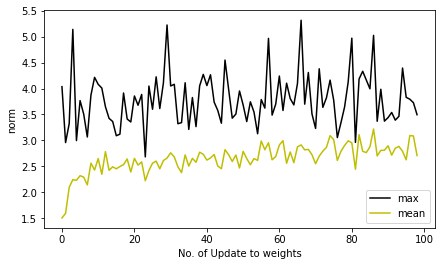

In [11]:
plot_data(hess_list)

In [87]:
# plot_data(grad_list)

In [88]:
# plot_data(hess_list)

In [89]:
# plot_data(gen_err_list, y_label='gen error')

In [1]:

li = []
count = 0
freq = 20
for i in range(20000):
    if i%freq==0:
        count+=1
        li.append(i)
        if count%100==0:
            freq += 20

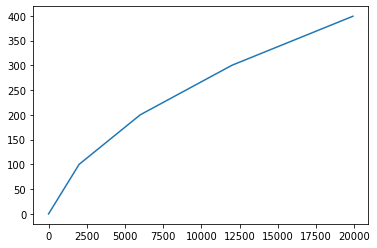

In [5]:
import matplotlib.pyplot as plt
plt.plot(li, range(400))